# 200 - First percepton with pytorch

First perception on MNIST database.

**Note:** install [tqdm](https://pypi.python.org/pypi/tqdm) if not installed: ``!pip install tqdm``

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
from pylab import plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm

torch 0.2.1+a4fc05a


In [2]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
DATA_DIR = 'data/'
USE_CUDA = True
N_EPOCHS = 100

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True)

In [4]:
data, target = next(i for i in train_loader)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
model = Net()

if USE_CUDA: 
    try:
        model = model.cuda()
    except Exception as e:
        print(e)
        USE_CUDA = False
        N_EPOCHS = 5


Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx


In [7]:
optimizer = optim.Adam(model.parameters())

In [8]:
def train(epoch, verbose=True):
    model.train()
    losses = []
    loader = tqdm(train_loader, total=len(train_loader))
    for batch_idx, (data, target) in enumerate(loader):
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.data[0]))
        if verbose and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    return np.mean(losses)

In [9]:
def test(verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if USE_CUDA: 
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return [float(test_loss), correct]

In [10]:
perfs = []
for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    train_loss = train(epoch, verbose=False)
    test_loss, correct = test(verbose=False)
    perfs.append([epoch, train_loss, test_loss, correct, len(test_loader.dataset), time.time() - t0])
    print("epoch {}: train loss {:.4f}, test loss {:.4f}, accuracy {}/{} in {:.2f}s".format(*perfs[-1]))

100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 165.78it/s]


epoch 1: train loss 0.4869, test loss 0.2487, accuracy 9292/10000 in 6.40s


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 161.32it/s]


epoch 2: train loss 0.3361, test loss 0.2154, accuracy 9352/10000 in 6.60s


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 164.34it/s]


epoch 3: train loss 0.3111, test loss 0.1984, accuracy 9389/10000 in 6.38s


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 169.42it/s]


epoch 4: train loss 0.2955, test loss 0.1883, accuracy 9441/10000 in 6.23s


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 173.92it/s]


epoch 5: train loss 0.2858, test loss 0.1881, accuracy 9441/10000 in 6.15s


In [11]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss", "accuracy", "n_test", "time"])
df_perfs

,epoch,train_loss,test_loss,accuracy,n_test,time
0,1,0.486896,0.248728,9292,10000,6.403531
1,2,0.336120,0.215425,9352,10000,6.599546
2,3,0.311113,0.198439,9389,10000,6.382548
3,4,0.295522,0.188293,9441,10000,6.234688
4,5,0.285847,0.188130,9441,10000,6.150301


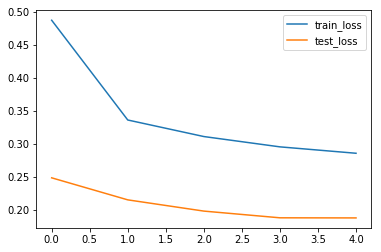

In [12]:
df_perfs[["train_loss", "test_loss"]].plot();

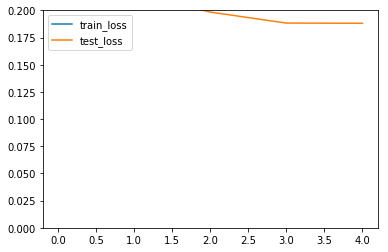

In [13]:
df_perfs[["train_loss", "test_loss"]].plot(ylim=(0, 0.2));